#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Sentiment Analysis`:
##### How well can we predict a restaurant’s Zomato score using the polarity of their reviews as input?

#### Group:
- `Laura Matias (20221836)`
- `Marta Almendra (20221878)`
- `Marta Aliende (20241453)`
- `Matilde Casimiro (20221940)` 
- `Teresa Simão (20221873)` 

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Preprocess Data ](#P1)
- [2. Sentiment Analysis ](#P1)
    - [2.1. Perform Sentiment Analysis using the VADER Sentiment Analyser](#P13)
        - [2.1.1 Assess the overall results against the review ratings](#P15)
    - [2.2. Perform Sentiment Analysis using the TextBlob Sentiment Analyser](#P14)
        - [2.2.1 Assess the overall results against the review ratings](#P15)

- [3. Compare and Visualize the results of VADER and TextBlob](#P2)
    - [3.1 Visualizations for general understanding](#P15)
    - [3.2 Vader VS Textblob](#P15)

- [4. Modelling](#P3)
    - [4.1 Linear Regression](#P15)
    - [4.2 Random Forest](#P15)
    - [4.3 Gradient Boosting Regressor](#P15)
    - [4.4 Suport Vector Machine](#P15)
    - [4.5 Model Comparison](#P15)

<font color='#BFD72F' size=4> Import libraries</font> <a class="anchor" id="P"></a>

In [1]:
#General Purpose
import pandas as pd
import numpy as np 
import spacy
import random

#Preprocessing
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
sent_tokenizer = PunktSentenceTokenizer()
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from collections import defaultdict
from collections import Counter
from num2words import num2words
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler


#Sentiment Analysis 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.tokenize import sent_tokenize


#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import os
import networkx as nx
from tqdm import tqdm
tqdm.pandas()

# Metrics
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#Prediciton
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Functions
from project_utils import *

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

c:\Users\Marta\Desktop\universidade\3rd year\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<font color='#BFD72F' size=4> Loading necessary data </font> <a class="anchor" id="P"></a>

In [2]:
sent_reviews = pd.read_csv("data_hyderabad/10k_reviews_cleaned_no_pre_proc.csv", header=0)

In [3]:
restaurants = pd.read_csv("data_hyderabad/105_restaurants_cleaned.csv", header=0)

<font color='#BFD72F' size=6>1. Pre-Processing </font> <a class="anchor" id="p2"></a>

In [4]:
sent_reviews = sent_reviews.drop(columns=["Reviewer","Time","Pictures","Number_Reviews","Followers"])

In [5]:
sent_reviews.head()

,Restaurant,Review,Rating
0,Beyond Flavours,"The ambience was good, food was quite good . h...",5.0
1,Beyond Flavours,Ambience is too good for a pleasant evening. S...,5.0
2,Beyond Flavours,A must try.. great food great ambience. Thnx f...,5.0
3,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,5.0
4,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,5.0


In [6]:
sent_reviews['basic_clean_text'] = sent_reviews['Review'].apply(lambda x: sent_pre_process_pipeline(x))

In [7]:
# Drop rows where 'basic_clean_text' is empty
sent_reviews = sent_reviews[sent_reviews['basic_clean_text'].str.strip() != ""].reset_index(drop=True)

In [8]:
sent_reviews['basic_clean_text']

0       The ambience was good, food was quite good . h...
1       Ambience is too good for  pleasant evening. Se...
2        must try.. great food great ambience. Thnx fo...
3       Soumen das and Arun was  great guy. Only becau...
4       Food is good.we ordered Kodi drumsticks and ba...
                              ...                        
9943    Madhumathi Mahajan Well to start with nice cou...
9944    This place has never disappointed us.. The foo...
9945    Bad rating is mainly because of "Chicken Bone ...
9946     personally love and prefer Chinese Food. Had ...
9947    Checked in here to try some delicious chinese ...
Name: basic_clean_text, Length: 9948, dtype: object

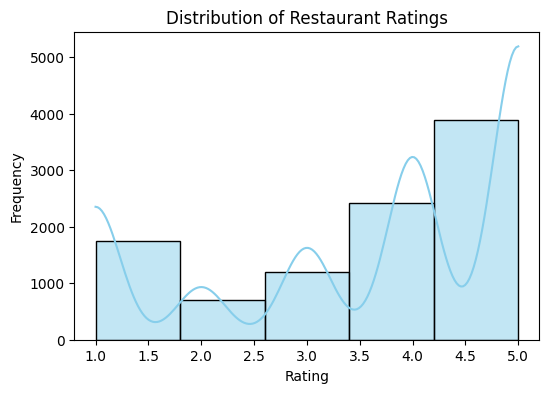

In [9]:
plt.figure(figsize=(6, 4))
sns.histplot(sent_reviews['Rating'], bins=5, kde=True, color="skyblue")
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


<font color='#BFD72F' size=6>2. Sentiment Analysis </font> <a class="anchor" id="p2"></a>

[Back to TOC](#toc)

<font color='#BFD72F' size=4> 2.1 Using VADER </font> <a class="anchor" id="P"></a>

In [10]:
vader = SentimentIntensityAnalyzer()

*In VADER , the `neg`, `neu`, and `pos` sum to 1.0, and the `compound` is the overall score for the sentence. It allows to get a sense of how many tokens are positive, negative, or neutral by taking a look at the respective scores.* 

In [11]:
example_review = sent_reviews['basic_clean_text'][0]
print(example_review)
vader.polarity_scores(example_review)

The ambience was good, food was quite good . had Saturday lunch , which was cost effective .
Good place for  sate brunch. One can also chill with friends and or parents.
Waiter Soumen Das was really courteous and helpful.


{'neg': 0.0, 'neu': 0.582, 'pos': 0.418, 'compound': 0.9664}

We decided to analyze the polarity of the reviews sentence by sentence, computing an average `compound` score and then compared it with the `compound` score of the reviews as a whole

In [12]:
def vader_wrapper(user_review, score):    
    if type(user_review) == list:
        sent_compound_list = []
        for sentence in user_review:
            sent_compound_list.append(vader.polarity_scores(sentence)[score])
        polarity = np.array(sent_compound_list).mean()
    else:
        polarity = vader.polarity_scores(user_review)[score]
    return polarity

In [13]:
for score in ['compound', 'neg', 'neu', 'pos']:
    sent_reviews[score+"_vader"] = sent_reviews["basic_clean_text"].map(lambda review: vader_wrapper(review, score))

    # Compute mean sentence polarity
    sent_reviews["mean_sentence_"+score+"_vader"] = sent_reviews["basic_clean_text"].map(
        lambda review: np.mean([vader_wrapper(sentence, score) for sentence in sent_tokenize(review)]))

In [14]:
sent_reviews[['Review','basic_clean_text','compound_vader','mean_sentence_compound_vader', 'neg_vader',
              'mean_sentence_neg_vader', 'neu_vader', 'mean_sentence_neu_vader', 'pos_vader', 'mean_sentence_pos_vader']].head()

,Review,basic_clean_text,compound_vader,mean_sentence_compound_vader,neg_vader,mean_sentence_neg_vader,neu_vader,mean_sentence_neu_vader,pos_vader,mean_sentence_pos_vader
0,"The ambience was good, food was quite good . h...","The ambience was good, food was quite good . h...",0.9664,0.57258,0.0,0.0,0.582,0.588400,0.418,0.411600
1,Ambience is too good for a pleasant evening. S...,Ambience is too good for pleasant evening. Se...,0.9360,0.42530,0.0,0.0,0.554,0.592800,0.446,0.407200
2,A must try.. great food great ambience. Thnx f...,must try.. great food great ambience. Thnx fo...,0.9186,0.47800,0.0,0.0,0.692,0.708667,0.308,0.291333
3,Soumen das and Arun was a great guy. Only beca...,Soumen das and Arun was great guy. Only becau...,0.8591,0.64230,0.0,0.0,0.708,0.676500,0.292,0.323500
4,Food is good.we ordered Kodi drumsticks and ba...,Food is good.we ordered Kodi drumsticks and ba...,0.9201,0.35955,0.0,0.0,0.609,0.539500,0.391,0.460500


In [15]:
pearson_r, p_value = pearsonr(sent_reviews["compound_vader"],sent_reviews["mean_sentence_compound_vader"])
pearson_r

0.8174823507517714

**2.1.1 Assess the overall results against the review ratings - correlations**

In [16]:
pearson_r, p_value = pearsonr(sent_reviews["Rating"],sent_reviews["compound_vader"])
pearson_r

0.693626534229606

In [17]:
pearson_r, p_value = pearsonr(sent_reviews["Rating"],sent_reviews["mean_sentence_compound_vader"])
pearson_r

0.6936387523309856

compound_vader                  0.693627
mean_sentence_compound_vader    0.693639
neg_vader                      -0.543224
mean_sentence_neg_vader        -0.552680
neu_vader                      -0.296089
mean_sentence_neu_vader        -0.286804
pos_vader                       0.533207
mean_sentence_pos_vader         0.528836
Name: Rating, dtype: float64


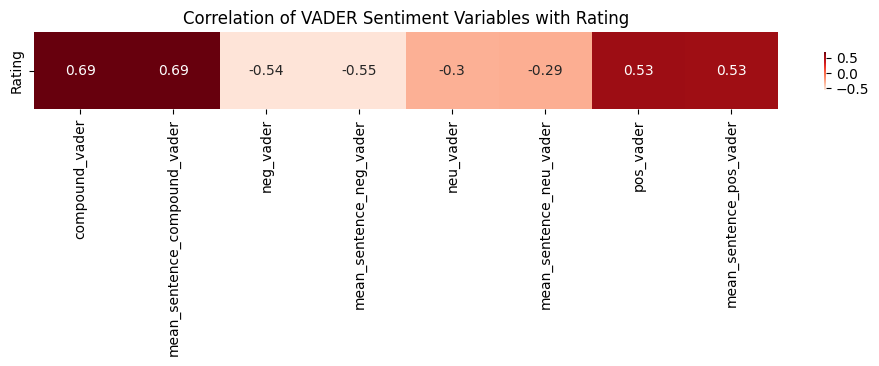

In [18]:
vader_sentiment_vars = ['compound_vader', 'mean_sentence_compound_vader', 'neg_vader',
                        'mean_sentence_neg_vader', 'neu_vader', 'mean_sentence_neu_vader',
                        'pos_vader', 'mean_sentence_pos_vader']

correlations = sent_reviews[vader_sentiment_vars + ['Rating']].corr()['Rating'].drop('Rating')
print(correlations)

plt.figure(figsize=(12, 1)) 
sns.heatmap(correlations.to_frame().T, annot=True, cmap='Reds', center=0, cbar_kws={"shrink": 0.5})

plt.title("Correlation of VADER Sentiment Variables with Rating")
plt.show()


**Normalize** the values. 

In [19]:
scaler = MinMaxScaler()
# Normalize the variables
normalized_rating = scaler.fit_transform(sent_reviews["Rating"].to_numpy().reshape(-1, 1))
normalized_polarity_vader = scaler.fit_transform(sent_reviews["compound_vader"].to_numpy().reshape(-1, 1))


#The "reshape(-1)" is there to flatten the 2D array into a 1D array
pearson_r, p_value = pearsonr(normalized_rating.reshape(-1), normalized_polarity_vader.reshape(-1))
pearson_r

0.6936265342296043

In [20]:
rmse = mean_squared_error(normalized_rating.reshape(-1), normalized_polarity_vader.reshape(-1), squared=False)

#adding constant to avoid division by zero and avoid unreasonabily high results
mape = mean_absolute_percentage_error(normalized_rating.reshape(-1)+1, normalized_polarity_vader.reshape(-1)+1)

print("RMSE: {}; MAPE: {}".format(round(rmse, 3), round(mape, 3)))

RMSE: 0.284; MAPE: 0.152


In [21]:
sent_reviews["normalized_rating"] = normalized_rating.reshape(-1)
sent_reviews["normalized_polarity_vader"] = normalized_polarity_vader.reshape(-1)
sent_reviews.describe()

,Rating,compound_vader,mean_sentence_compound_vader,neg_vader,mean_sentence_neg_vader,neu_vader,mean_sentence_neu_vader,pos_vader,mean_sentence_pos_vader,normalized_rating,normalized_polarity_vader
count,9948.000000,9948.000000,9948.000000,9948.000000,9948.000000,9948.000000,9948.000000,9948.000000,9948.000000,9948.000000,9948.000000
mean,3.599819,0.486570,0.275336,0.053208,0.053795,0.694357,0.688838,0.251628,0.249006,0.649955,0.742469
std,1.483459,0.574969,0.357748,0.110456,0.113934,0.219429,0.224106,0.233087,0.235340,0.370865,0.288567
min,1.000000,-0.992800,-0.972100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.051600,0.009038,0.000000,0.000000,0.626000,0.610000,0.091000,0.082312,0.500000,0.524166
50%,4.000000,0.774200,0.317108,0.000000,0.000000,0.737000,0.733000,0.205000,0.199739,0.750000,0.886826
75%,5.000000,0.935500,0.492700,0.065000,0.058893,0.826000,0.829000,0.340000,0.340667,1.000000,0.967779
max,5.000000,0.999700,0.995000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The average value of the normalized_polarity_vader is higher than the normalized_rating, which could indicate that VADER perceives the tone of the reviews as slightly more positive (comparing to the normalized numerical ratings in reviews).

<font color='#BFD72F' size=4> 2.2 Using TextBlob </font> <a class="anchor" id="P"></a>

In [22]:
test_blob = TextBlob(example_review)
test_blob.sentiment

Sentiment(polarity=0.66, subjectivity=0.72)

In [23]:
def textblob_wrapper(user_review):   
    if type(user_review) == list:
        sent_compound_list = []
        for sentence in user_review:
            sent_compound_list.append(TextBlob(sentence).sentiment.polarity)
        polarity = np.array(sent_compound_list).mean()
    else:
        polarity = TextBlob(user_review).sentiment.polarity
    return polarity

In [24]:
sent_reviews["content_polarity_textblob"] = sent_reviews["basic_clean_text"].map(lambda review: textblob_wrapper(review))

sent_reviews["mean_sentence_polarity_textblob"] = sent_reviews["basic_clean_text"].map(
    lambda review: np.mean([textblob_wrapper(sentence) for sentence in sent_tokenize(review)]))

In [25]:
pearson_r, p_value = pearsonr(sent_reviews["mean_sentence_polarity_textblob"],sent_reviews["content_polarity_textblob"])
pearson_r

0.9540125128394714

In [26]:
sent_reviews[['Review','basic_clean_text', 'content_polarity_textblob', 'mean_sentence_polarity_textblob']].sample(5)

,Review,basic_clean_text,content_polarity_textblob,mean_sentence_polarity_textblob
5579,This has been a good find! Almond and au choco...,This has been good find! Almond and au chocol...,0.327941,3.625000e-01
8417,Biryani taste is not at all good.\nBiryani tas...,Biryani taste is not at all good.\nBiryani tas...,0.530000,3.785714e-01
3715,Only masala is der in biryani tooooo much spic...,Only masala is der in biryani too much spicy a...,0.050000,5.000000e-02
8331,Ordered a burger from this place and it is so ...,Ordered burger from this place and it is so d...,0.025000,-7.930164e-18
7302,Late night craving for some coffee and chocola...,Late night craving for some coffee and chocola...,0.262500,1.375000e-01


**2.2.1 Assess the overall results against the review ratings - correlations**

In [27]:
pearson_r, p_value = pearsonr(sent_reviews["Rating"],sent_reviews["content_polarity_textblob"])
pearson_r

0.6961517005440864

Normalizing and Metrics

In [28]:
normalized_polarity_textblob = scaler.fit_transform(sent_reviews["content_polarity_textblob"].to_numpy().reshape(-1, 1))
sent_reviews["normalized_polarity_textblob"] = normalized_polarity_textblob.reshape(-1)

pearson_r, p_value = pearsonr(normalized_rating.reshape(-1), normalized_polarity_textblob.reshape(-1))

In [29]:
rmse = mean_squared_error(normalized_rating.reshape(-1), normalized_polarity_textblob.reshape(-1), squared=False)
mape = mean_absolute_percentage_error(normalized_rating.reshape(-1)+1, normalized_polarity_textblob.reshape(-1)+1)

print("Pearson R: {}; RMSE: {}; MAPE: {}".format(round(pearson_r, 3), round(rmse, 3), round(mape, 3)))

Pearson R: 0.696; RMSE: 0.278; MAPE: 0.159


<font color='#BFD72F' size=6>3. Model Comparison </font> <a class="anchor" id="p2"></a>

<font color='#BFD72F' size=4> 3.1 Overall Understanding Visualizations </font> <a class="anchor" id="P"></a>

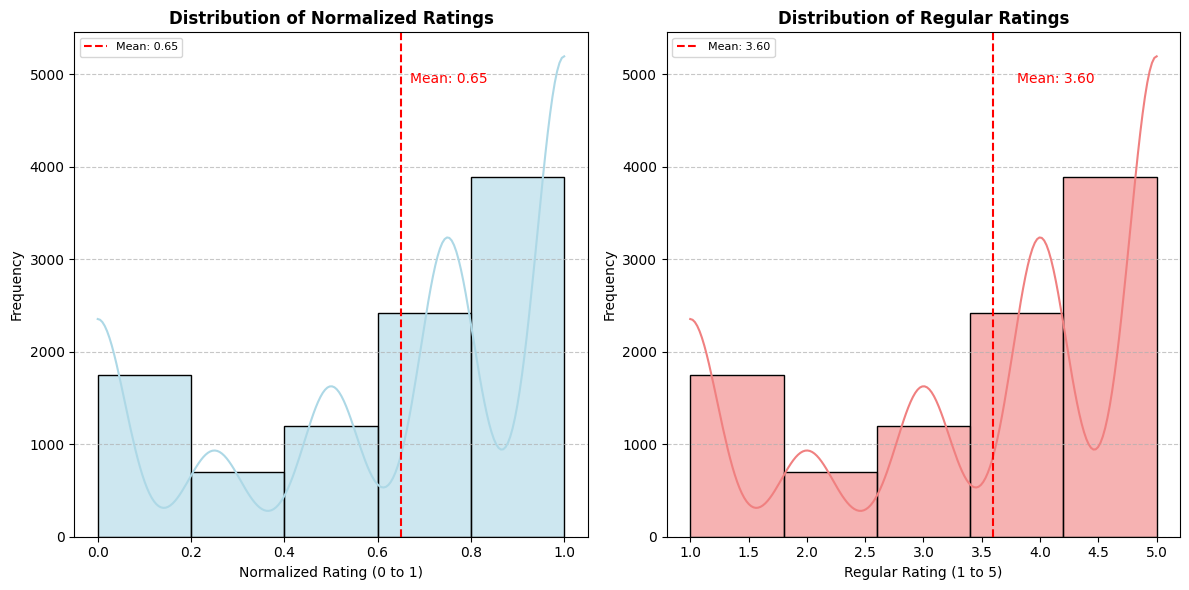

In [30]:
plt.figure(figsize=(12, 6))

# distribution of normalized ratings
plt.subplot(1, 2, 1) 
sns.histplot(sent_reviews['normalized_rating'], bins=5, kde=True, color='lightblue', alpha=0.6, edgecolor='black')
plt.title('Distribution of Normalized Ratings', fontsize=12, fontweight='bold')
plt.xlabel('Normalized Rating (0 to 1)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
mean_normalized_rating = sent_reviews['normalized_rating'].mean()
plt.axvline(mean_normalized_rating, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_normalized_rating:.2f}')
plt.text(mean_normalized_rating + 0.02, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_normalized_rating:.2f}', color='red')
plt.legend(loc='upper left', fontsize=8)

# distribution of regular ratings
plt.subplot(1, 2, 2) 
sns.histplot(sent_reviews['Rating'], bins=5, kde=True, color='lightcoral', alpha=0.6, edgecolor='black')
plt.title('Distribution of Regular Ratings', fontsize=12, fontweight='bold')
plt.xlabel('Regular Rating (1 to 5)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
mean_regular_rating = sent_reviews['Rating'].mean()
plt.axvline(mean_regular_rating, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_regular_rating:.2f}')
plt.text(mean_regular_rating + 0.2, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_regular_rating:.2f}', color='red')
plt.legend(loc='upper left', fontsize=8)

plt.tight_layout()  
plt.show()

<font color='#BFD72F' size=4> 3.2 Vader VS TextBlob </font> <a class="anchor" id="P"></a>

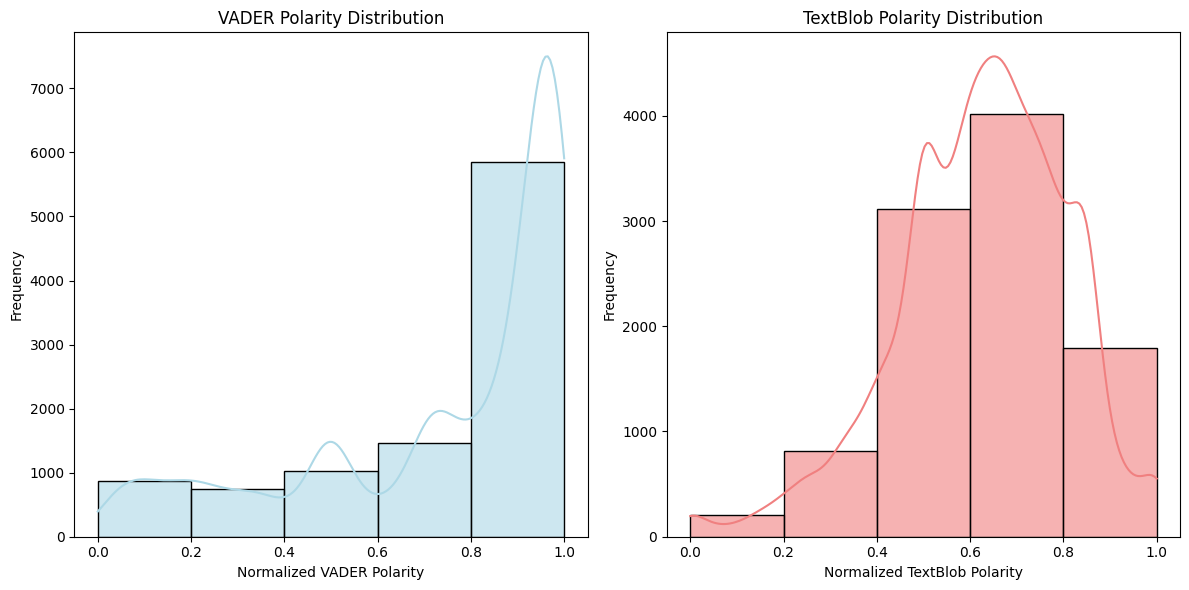

In [31]:
# Side-by-side histograms for VADER and TextBlob polarities
plt.figure(figsize=(12, 6))

# Plot for VADER
plt.subplot(1, 2, 1)
sns.histplot(sent_reviews['normalized_polarity_vader'], bins=5, kde=True, color='lightblue', alpha=0.6, edgecolor='black')
plt.title('VADER Polarity Distribution', fontsize=12,)
plt.xlabel('Normalized VADER Polarity', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Plot for TextBlob
plt.subplot(1, 2, 2)
sns.histplot(sent_reviews['normalized_polarity_textblob'], bins=5, kde=True, color='lightcoral', alpha=0.6, edgecolor='black')
plt.title('TextBlob Polarity Distribution', fontsize=12)
plt.xlabel('Normalized TextBlob Polarity', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.tight_layout()
plt.show()


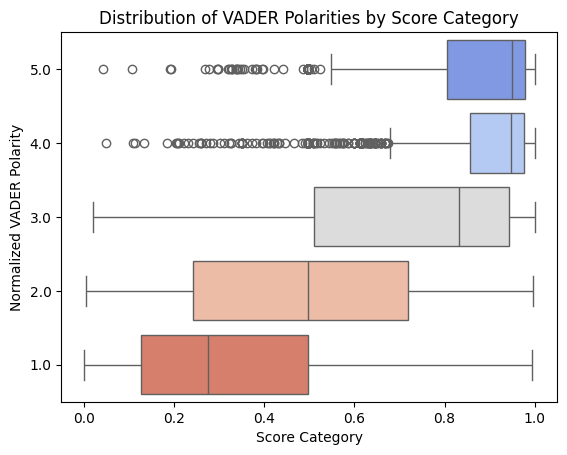

In [32]:
sent_reviews["overall_rating"] = sent_reviews["Rating"].apply(lambda score : str(score))

sns.boxplot(data=sent_reviews,  palette='coolwarm', x="normalized_polarity_vader", y="overall_rating", order=["5.0", "4.0", "3.0", "2.0", "1.0"])
plt.title('Distribution of VADER Polarities by Score Category')
plt.xlabel('Score Category')
plt.ylabel('Normalized VADER Polarity')
plt.show() 

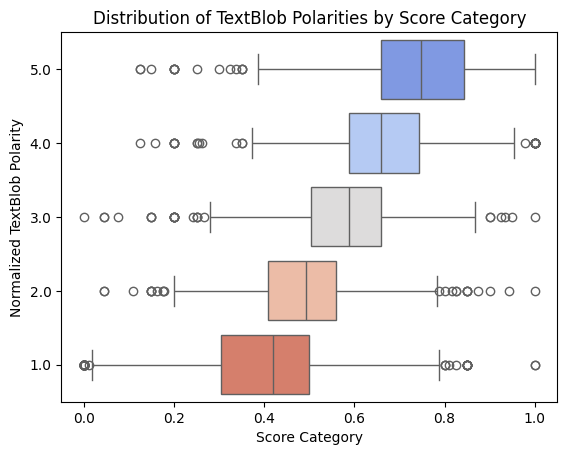

In [33]:
sns.boxplot(data=sent_reviews,  palette='coolwarm', x="normalized_polarity_textblob", y="overall_rating", order=["5.0", "4.0", "3.0", "2.0", "1.0"])
plt.title('Distribution of TextBlob Polarities by Score Category')
plt.xlabel('Score Category')
plt.ylabel('Normalized TextBlob Polarity')
plt.show()

Text(0, 0.5, 'Normalized TextBlob Polarity')

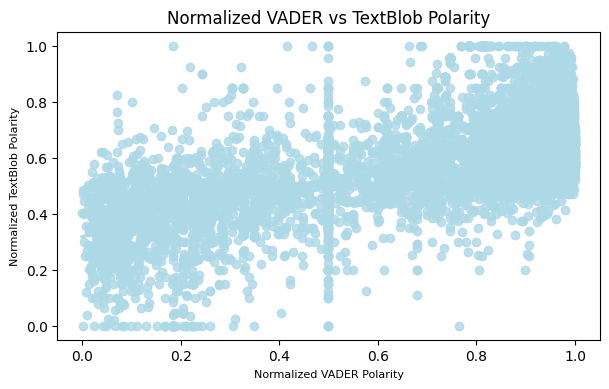

In [34]:
plt.figure(figsize=(7, 4))  
sns.regplot(data=sent_reviews, x="normalized_polarity_vader", y="normalized_polarity_textblob", color = 'lightblue')
plt.title('Normalized VADER vs TextBlob Polarity', fontsize=12)
plt.xlabel('Normalized VADER Polarity', fontsize=8)
plt.ylabel('Normalized TextBlob Polarity', fontsize=8)


In [35]:
pearson_r, p_value = pearsonr(sent_reviews["normalized_polarity_vader"],sent_reviews["normalized_polarity_textblob"])
pearson_r

0.6554618201149899

<font color='#BFD72F' size=6>4. Modelling </font> <a class="anchor" id="p2"></a>


[Back to TOC](#toc)

In [36]:
reviews_model = sent_reviews[['normalized_polarity_vader', 'normalized_polarity_textblob', 'normalized_rating']]

In [37]:
reviews_model.head()

,normalized_polarity_vader,normalized_polarity_textblob,normalized_rating
0,0.983287,0.830000,1.0
1,0.968030,0.803333,1.0
2,0.959297,0.770000,1.0
3,0.929435,0.750000,1.0
4,0.960050,0.788750,1.0


In [38]:
X = reviews_model.drop(columns=['normalized_rating']) 
y = reviews_model['normalized_rating']               

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


X_train: (7958, 2), X_test: (1990, 2)
y_train: (7958,), y_test: (1990,)


<font color='#BFD72F' size=4> 4.1. Linear Regression </font> <a class="anchor" id="P"></a>

In [39]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)  
predictions_lr = model_lr.predict(X_test)

In [40]:
# Calculate Mean Squared Error
mse_lr = mean_squared_error(y_test, predictions_lr)
print("Mean Squared Error:", mse_lr)

# Calculate R² score
r2_lr = r2_score(y_test, predictions_lr)
print("R² score:", r2_lr)

Mean Squared Error: 0.056660419001659384
R² score: 0.5895790229871644


<font color='#BFD72F' size=4> 4.2. Random Forest </font> <a class="anchor" id="p42"></a>

In [41]:
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)

In [42]:
# Calculate Mean Squared Error
mse_rf = mean_squared_error(y_test, predictions_rf)
print("Mean Squared Error:", mse_rf)

# Calculate R² score
r2_rf = r2_score(y_test, predictions_rf)
print("R² score:", r2_rf)

Mean Squared Error: 0.06196394186229318
R² score: 0.5511628398310271


<font color='#BFD72F' size=4> 4.3. Gradient Boosting Regressor </font> <a class="anchor" id="P"></a>

In [43]:
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)
predictions_gb = model_gb.predict(X_test)

In [44]:
# Calculate Mean Squared Error
mse_gb = mean_squared_error(y_test, predictions_gb)
print("Mean Squared Error:", mse_gb)

# Calculate R² score
r2_gb = r2_score(y_test, predictions_gb)
print("R² score:", r2_gb)

Mean Squared Error: 0.05401702161941479
R² score: 0.6087265294011608


<font color='#BFD72F' size=4> 4.4. Support Vector Machine </font> <a class="anchor" id="P"></a>

In [45]:
model_svm = SVR(kernel='rbf')  # rbf for non-linear relationships
model_svm.fit(X_train, y_train)
predictions_svm = model_svm.predict(X_test)

In [46]:
# Calculate Mean Squared Error
mse_svm = mean_squared_error(y_test, predictions_svm)
print("Mean Squared Error:", mse_svm)

# Calculate R² score
r2_svm = r2_score(y_test, predictions_svm)
print("R² score:", r2_svm)

Mean Squared Error: 0.05745773733660797
R² score: 0.5838036302917756


<font color='#BFD72F' size=4> 4.5. Model Comparison </font> <a class="anchor" id="P"></a>

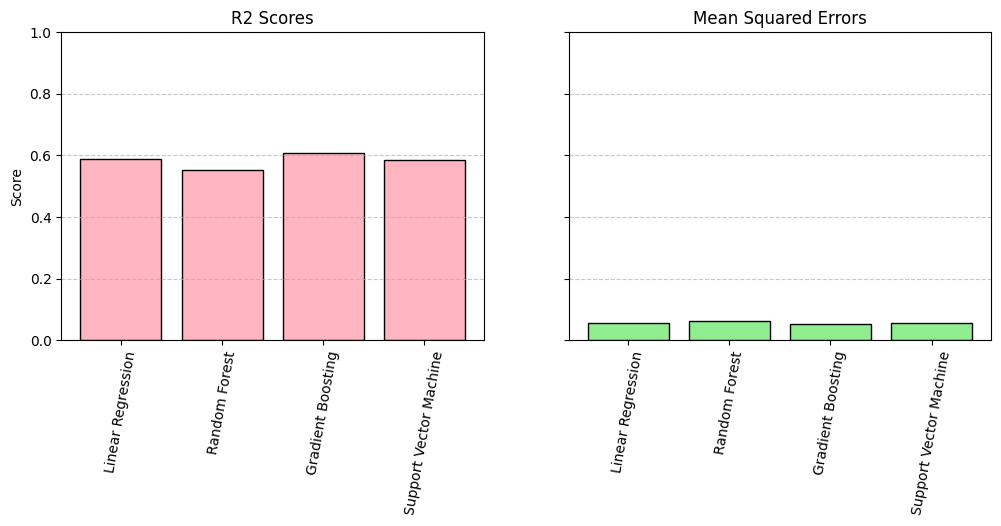

In [47]:
model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine']
r2_scores = [r2_lr, r2_rf, r2_gb, r2_svm]
mse_scores = [mse_lr, mse_rf, mse_gb, mse_svm]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Plot F1 Scores
axes[0].bar(model_names, r2_scores, color='lightpink', edgecolor='black')
axes[0].set_title('R2 Scores')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=80)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot Recalls
axes[1].bar(model_names, mse_scores, color='lightgreen', edgecolor='black')
axes[1].set_title('Mean Squared Errors')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=80)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)